In [1]:
!pip install fredapi

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

TICKERS = ['XLF', 'SPY', 'XLE', 'XLK', 'XLV', 'XLI', 'XLU', 'IYR', 'IYT', 'GLD']
START_DATE = '1999-01-01'
END_DATE = pd.to_datetime('today').strftime('%Y-%m-%d')

def get_etf_data(tickers, start=START_DATE, end=END_DATE):
    price_df = yf.download(tickers, start=start, end=end, auto_adjust=True)['Close']
    log_returns = np.log(price_df / price_df.shift(1)).dropna()
    return price_df, log_returns

etf_prices, etf_log_returns = get_etf_data(TICKERS)

display(etf_prices.head())
display(etf_log_returns.head())


[*********************100%***********************]  10 of 10 completed


Ticker,GLD,IYR,IYT,SPY,XLE,XLF,XLI,XLK,XLU,XLV
Date,,,,,,,,,,
1999-01-04,NaN,NaN,NaN,77.117310,11.777606,11.357698,15.169421,24.655313,11.882613,17.623884
1999-01-05,NaN,NaN,NaN,77.998772,11.714495,11.463698,15.482602,25.285709,12.026150,17.899923
1999-01-06,NaN,NaN,NaN,79.879173,12.101032,11.827150,15.815330,26.032827,12.150970,18.197189
1999-01-07,NaN,NaN,NaN,79.487427,12.045816,12.008873,15.678329,25.951126,12.107290,18.112257
1999-01-08,NaN,NaN,NaN,80.075073,12.101032,12.084584,15.795767,26.056185,12.175930,18.335209


Ticker,GLD,IYR,IYT,SPY,XLE,XLF,XLI,XLK,XLU,XLV
Date,,,,,,,,,,
2004-11-19,0.008973,-0.013805,-0.011897,-0.011179,0.011890,-0.012891,-0.012113,-0.015585,-0.003656,-0.012244
2004-11-22,0.003789,0.007444,0.010359,0.004758,0.015817,0.005787,0.002303,0.001427,0.015628,0.001759
2004-11-23,-0.004459,0.010636,0.002919,0.001524,0.006203,0.002373,-0.001644,-0.004287,0.006112,-0.003167
2004-11-24,0.006682,0.013560,0.009312,0.002367,0.008301,0.004056,0.004597,0.008082,0.003577,0.002465
2004-11-26,0.005313,-0.005910,0.000456,-0.000760,0.004258,0.000674,0.000000,-0.001421,0.003921,0.005960


In [3]:
from fredapi import Fred

FRED_API_KEY = '07d9e030d39607f3ce86d41362f27e45'

FRED_KEYS = [
    'CPIAUCSL',
    'UNRATE',
    'DFF',
    'GDPC1',
    'INDPRO',
    'PAYEMS',
    'HOUST',
    'M2SL',
    'DTWEXBGS'
]

START_DATE = '1999-01-01'
END_DATE = pd.to_datetime('today').strftime('%Y-%m-%d')

fred = Fred(api_key=FRED_API_KEY)

macro_data = pd.DataFrame({key: fred.get_series(key, START_DATE, END_DATE) for key in FRED_KEYS})
macro_data.index = pd.to_datetime(macro_data.index)

macro_daily_df = macro_data.resample('D').ffill()

display(macro_daily_df.head())


,CPIAUCSL,UNRATE,DFF,GDPC1,INDPRO,PAYEMS,HOUST,M2SL,DTWEXBGS
1999-01-01,164.7,4.3,4.07,13315.597,87.2205,127699.0,1748.0,4403.0,NaN
1999-01-02,NaN,NaN,4.07,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-03,NaN,NaN,4.07,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-04,NaN,NaN,5.04,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-05,NaN,NaN,4.54,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import requests
import re
from bs4 import BeautifulSoup
from textblob import TextBlob

base_url = "https://www.federalreserve.gov"
fomc_links = []

for year in range(1999, 2025):
    url = f"{base_url}/monetarypolicy/fomchistorical{year}.htm"
    res = requests.get(url)
    soup = BeautifulSoup(res.content, "html.parser")
    links = soup.find_all("a", href=re.compile(r"/newsevents/pressreleases/monetary\d{8}a\.htm"))
    for link in links:
        href = link.get("href")
        date_match = re.search(r"(\d{8})", href)
        if date_match:
            date_str = date_match.group(1)
            fomc_links.append({
                "date": pd.to_datetime(date_str),
                "url": base_url + href
            })

fomc_df = pd.DataFrame(fomc_links)

def fetch_minutes_text(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        content = soup.find("div", {"class": "col-xs-12 col-sm-8 col-md-8"})
        return content.get_text(strip=True) if content else None
    except:
        return None

fomc_df['minutes_text'] = fomc_df['url'].apply(fetch_minutes_text)

def compute_sentiment(text):
    if text:
        return TextBlob(text).sentiment.polarity
    return None

fomc_df['sentiment_score'] = fomc_df['minutes_text'].apply(compute_sentiment)

fomc_df = fomc_df.set_index('date').sort_index()
fomc_daily = fomc_df[['sentiment_score']].resample('D').ffill()

display(fomc_daily.head())


,sentiment_score
date,
2011-01-26,0.086306
2011-01-27,0.086306
2011-01-28,0.086306
2011-01-29,0.086306
2011-01-30,0.086306


In [5]:
merged_df = etf_log_returns.copy()

merged_df = merged_df.merge(macro_daily_df, left_index=True, right_index=True, how='left')

merged_df = merged_df.merge(fomc_daily, left_index=True, right_index=True, how='left')

merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

merged_df.dropna(subset=etf_log_returns.columns, inplace=True)

print(f"Merged DataFrame shape: {merged_df.shape}")
display(merged_df.head())


Merged DataFrame shape: (5207, 20)


,GLD,IYR,IYT,SPY,XLE,XLF,XLI,XLK,XLU,XLV,CPIAUCSL,UNRATE,DFF,GDPC1,INDPRO,PAYEMS,HOUST,M2SL,DTWEXBGS,sentiment_score
Date,,,,,,,,,,,,,,,,,,,,
2004-11-19,0.008973,-0.013805,-0.011897,-0.011179,0.011890,-0.012891,-0.012113,-0.015585,-0.003656,-0.012244,191.7,5.4,1.99,15922.782,95.5415,132629.0,2042.0,6424.7,100.7558,0.086306
2004-11-22,0.003789,0.007444,0.010359,0.004758,0.015817,0.005787,0.002303,0.001427,0.015628,0.001759,191.7,5.4,2.01,15922.782,95.5415,132629.0,2042.0,6424.7,100.7558,0.086306
2004-11-23,-0.004459,0.010636,0.002919,0.001524,0.006203,0.002373,-0.001644,-0.004287,0.006112,-0.003167,191.7,5.4,2.00,15922.782,95.5415,132629.0,2042.0,6424.7,100.7558,0.086306
2004-11-24,0.006682,0.013560,0.009312,0.002367,0.008301,0.004056,0.004597,0.008082,0.003577,0.002465,191.7,5.4,2.02,15922.782,95.5415,132629.0,2042.0,6424.7,100.7558,0.086306
2004-11-26,0.005313,-0.005910,0.000456,-0.000760,0.004258,0.000674,0.000000,-0.001421,0.003921,0.005960,191.7,5.4,2.01,15922.782,95.5415,132629.0,2042.0,6424.7,100.7558,0.086306


In [6]:
def add_technical_indicators(df, price_data, tickers):

    for ticker in tickers:
        series = price_data[ticker]

        df[f'{ticker}_SMA_20'] = series.rolling(window=20).mean()
        df[f'{ticker}_SMA_50'] = series.rolling(window=50).mean()

        delta = series.diff()
        gain = delta.where(delta > 0, 0).rolling(window=14).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
        rs = gain / loss
        df[f'{ticker}_RSI'] = 100 - (100 / (1 + rs))

        exp12 = series.ewm(span=12, adjust=False).mean()
        exp26 = series.ewm(span=26, adjust=False).mean()
        macd = exp12 - exp26
        signal = macd.ewm(span=9, adjust=False).mean()
        df[f'{ticker}_MACD'] = macd
        df[f'{ticker}_MACD_signal'] = signal

    return df.dropna()

merged_df = add_technical_indicators(merged_df, etf_prices, TICKERS)
display(merged_df.tail())


,GLD,IYR,IYT,SPY,XLE,XLF,XLI,XLK,XLU,XLV,...,IYT_SMA_20,IYT_SMA_50,IYT_RSI,IYT_MACD,IYT_MACD_signal,GLD_SMA_20,GLD_SMA_50,GLD_RSI,GLD_MACD,GLD_MACD_signal
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-28,-0.006495,-0.017026,-0.001545,-0.000251,0.011302,-0.006948,-0.003102,0.007946,-0.010705,-0.008757,...,70.6680,68.046778,50.488962,0.938932,1.083116,308.231502,307.3440,52.170890,0.609361,0.825825
2025-07-29,0.002747,0.016821,-0.028520,-0.002641,0.009715,-0.005101,-0.011456,0.000038,0.011415,-0.006377,...,70.6975,68.080123,41.675065,0.742912,1.015075,308.302502,307.5122,51.291138,0.347994,0.730258
2025-07-30,-0.017424,-0.014534,-0.013544,-0.001260,-0.014381,-0.001896,-0.004922,0.002232,0.007421,-0.001787,...,70.6235,68.079508,26.101284,0.506682,0.913396,307.973003,307.6466,42.031607,-0.282742,0.527658
2025-07-31,0.006623,-0.014959,-0.002937,-0.003758,-0.005375,-0.006282,0.000066,-0.007357,0.005384,-0.028420,...,70.5095,68.078483,28.080554,0.299872,0.790692,307.658502,307.7452,40.325584,-0.614142,0.299298
2025-08-01,0.020096,-0.001371,-0.020503,-0.016526,-0.018751,-0.018696,-0.015046,-0.021816,0.001516,0.005353,...,70.3080,68.062226,25.185952,0.024339,0.637421,307.757001,307.8558,51.488061,-0.376189,0.164201


In [7]:
def create_forward_log_returns(df, price_data, tickers, horizon=21):

    for ticker in tickers:
        future_price = price_data[ticker].shift(-horizon)
        log_return = np.log(future_price / price_data[ticker])
        df[f'{ticker}_Target'] = log_return
    return df.dropna()

merged_df = create_forward_log_returns(merged_df, etf_prices, TICKERS)
display(merged_df[[col for col in merged_df.columns if 'Target' in col]].head())


,XLF_Target,SPY_Target,XLE_Target,XLK_Target,XLV_Target,XLI_Target,XLU_Target,IYR_Target,IYT_Target,GLD_Target
Date,,,,,,,,,,
2005-01-31,0.000000,0.025155,0.150072,0.010984,0.038563,0.017723,0.022941,0.037444,0.040432,0.024103
2005-02-01,-0.012331,0.019240,0.149539,-0.002498,0.028048,0.017022,0.021424,0.024353,0.038100,0.020455
2005-02-02,0.000331,0.028597,0.148527,0.003486,0.033170,0.030881,0.033194,0.033570,0.057955,0.028527
2005-02-03,0.004979,0.031689,0.136707,0.017418,0.038492,0.038647,0.037458,0.046165,0.077220,0.042050
2005-02-04,-0.008587,0.017316,0.131994,-0.007929,0.022868,0.029767,0.021082,0.021979,0.070084,0.059901


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

feature_cols = [col for col in merged_df.columns if all(x not in col for x in ['Target'])]
target_cols = [col for col in merged_df.columns if 'Target' in col]

X = merged_df[feature_cols]
y = merged_df[target_cols]

split_idx = int(0.8 * len(merged_df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test_scaled shape:", y_test_scaled.shape)


X_train_scaled shape: (4110, 70)
y_train_scaled shape: (4110, 10)
X_test_scaled shape: (1028, 70)
y_test_scaled shape: (1028, 10)


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.1845 - mae: 0.3082 - val_loss: 0.0208 - val_mae: 0.1142
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0271 - mae: 0.1294 - val_loss: 0.0217 - val_mae: 0.1116
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - mae: 0.1065 - val_loss: 0.0309 - val_mae: 0.1399
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - mae: 0.0935 - val_loss: 0.0163 - val_mae: 0.0974
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - mae: 0.0826 - val_loss: 0.0158 - val_mae: 0.0961
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - mae: 0.0770 - val_loss: 0.0114 - val_mae: 0.0805
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - mae: 0.0723 - val_loss: 0.0104 - val_mae: 0.0764
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - mae: 0.0727 - val_loss: 0.0096 - val_mae: 0.0739
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

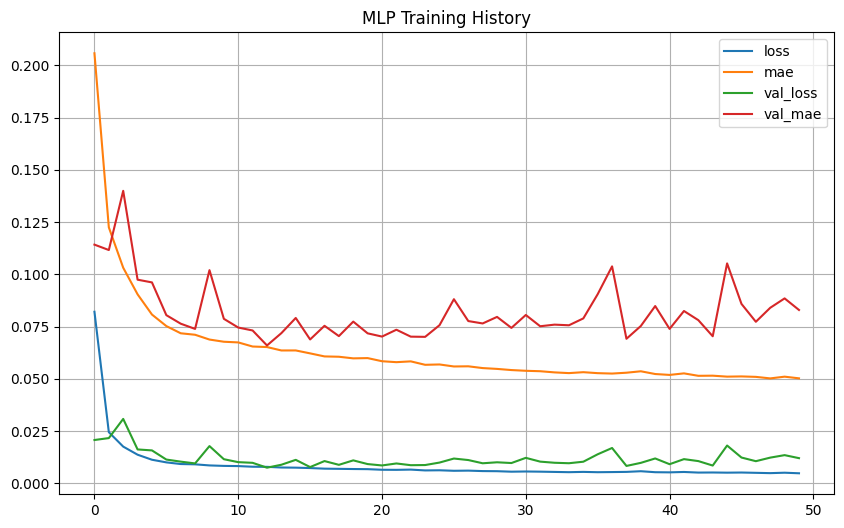

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
import matplotlib.pyplot as plt
import pandas as pd

mlp_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train_scaled.shape[1], activation='linear')
])

mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_mlp = mlp_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=1
)

pd.DataFrame(history_mlp.history).plot(title="MLP Training History", figsize=(10, 6), grid=True)
plt.show()


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1161 - mae: 0.2633 - val_loss: 0.0070 - val_mae: 0.0651
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0149 - mae: 0.0940 - val_loss: 0.0063 - val_mae: 0.0626
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0123 - mae: 0.0843 - val_loss: 0.0076 - val_mae: 0.0707
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112 - mae: 0.0802 - val_loss: 0.0057 - val_mae: 0.0586
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0098 - mae: 0.0744 - val_loss: 0.0061 - val_mae: 0.0613
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0092 - mae: 0.0708 - val_loss: 0.0060 - val_mae: 0.0608
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089 - mae: 0.0695 - val_loss: 0.0067 - val_mae: 0.0657
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - mae: 0.0695 - val_loss: 0.0063 - val_mae: 0.0603
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - 

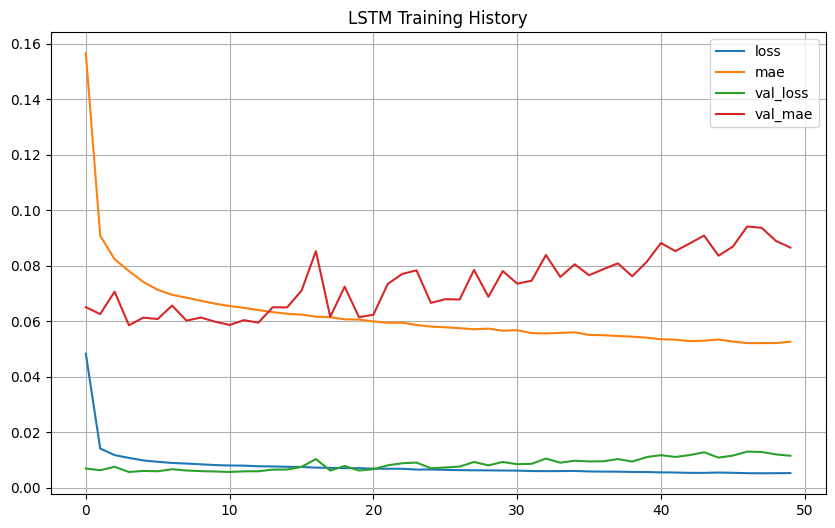

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
import numpy as np

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(y_train_scaled.shape[1], activation='linear')
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_lstm = lstm_model.fit(
    X_train_lstm, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(X_test_lstm, y_test_scaled),
    verbose=1
)

pd.DataFrame(history_lstm.history).plot(title="LSTM Training History", figsize=(10, 6), grid=True)
plt.show()


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_scaled, y_scaled, y_true_raw, scaler_y, model_name=""):
    y_pred_scaled = model.predict(X_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_scaled)

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.4f}")
    print()

    return y_pred, y_true

mlp_preds, mlp_true = evaluate_model(
    mlp_model, X_test_scaled, y_test_scaled, y_test, scaler_y, model_name="MLP"
)

lstm_preds, lstm_true = evaluate_model(
    lstm_model, X_test_lstm, y_test_scaled, y_test, scaler_y, model_name="LSTM"
)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MLP Performance:
  MSE:  0.007528
  MAE:  0.063183
  R²:   -1.4304

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
LSTM Performance:
  MSE:  0.006633
  MAE:  0.064764
  R²:   -1.2458



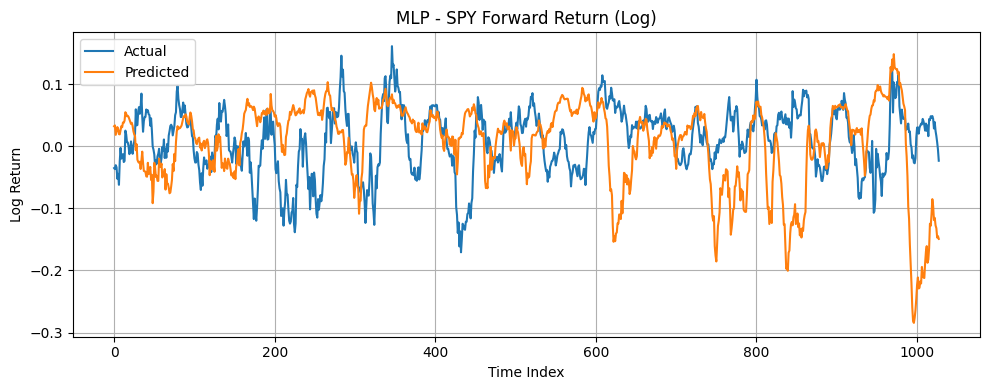

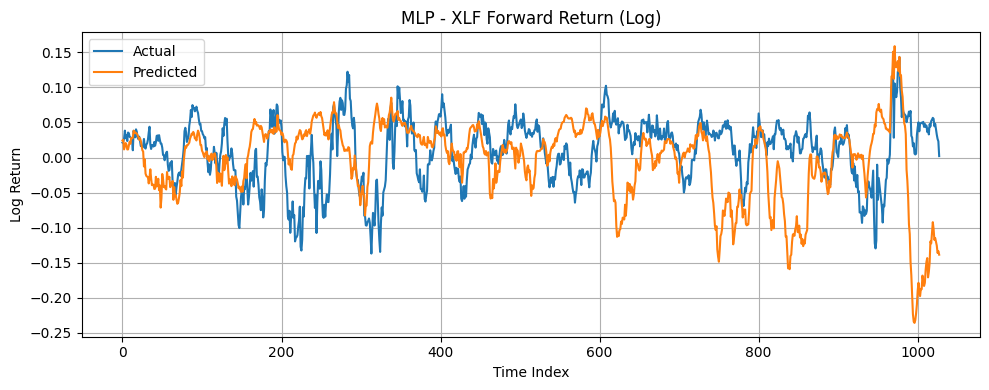

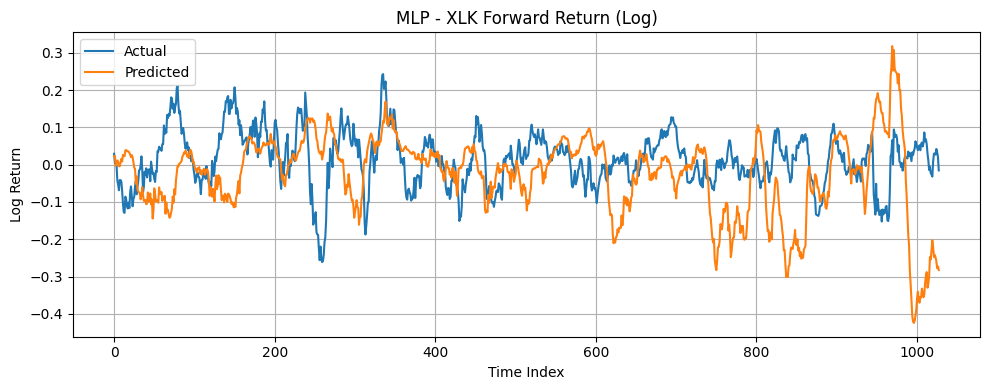

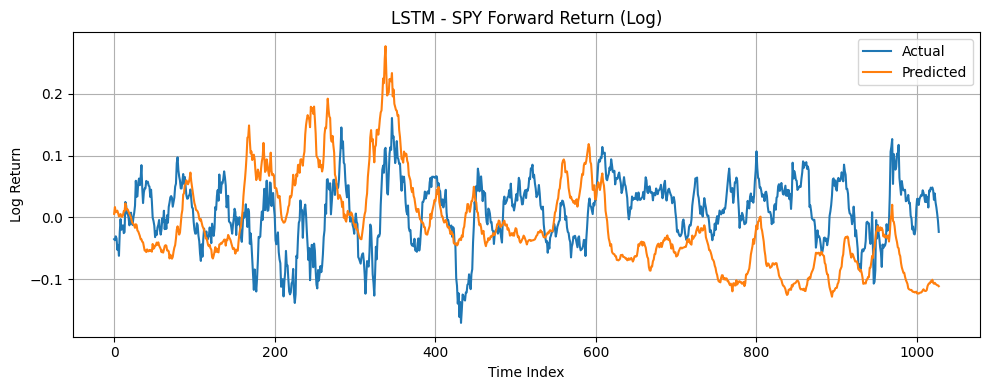

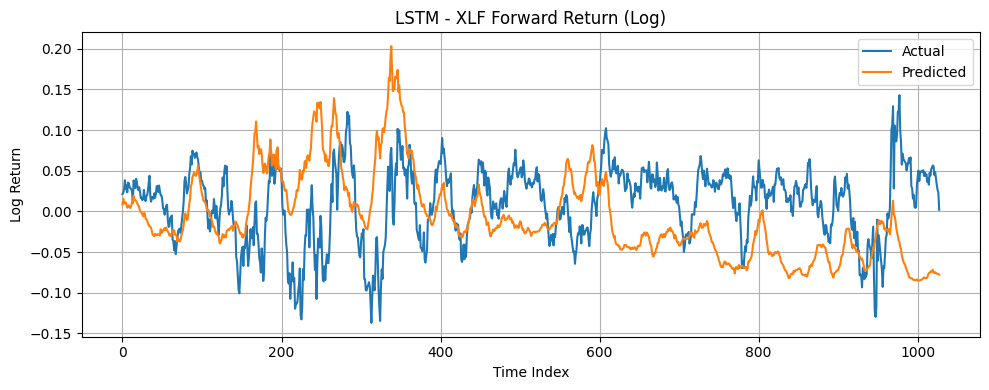

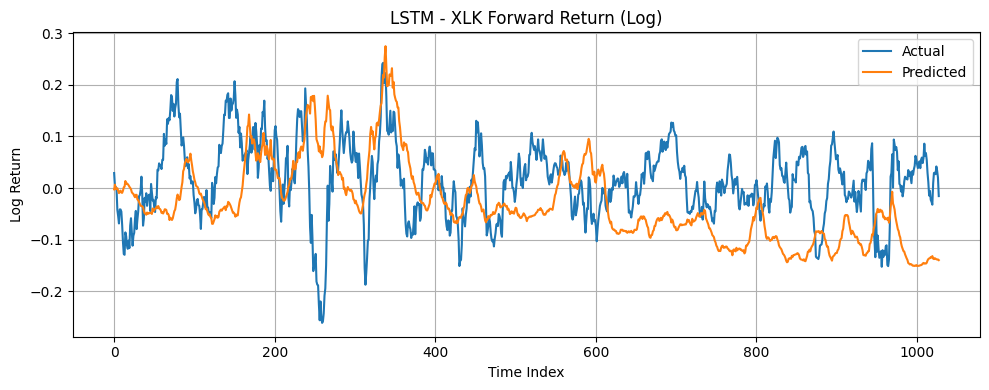

In [12]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, etfs, model_name):
    for i, ticker in enumerate(etfs):
        plt.figure(figsize=(10, 4))
        plt.plot(y_true[:, i], label='Actual')
        plt.plot(y_pred[:, i], label='Predicted')
        plt.title(f'{model_name} - {ticker} Forward Return (Log)')
        plt.xlabel("Time Index")
        plt.ylabel("Log Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

selected_etfs = ['SPY', 'XLF', 'XLK']
etf_indices = [TICKERS.index(t) for t in selected_etfs]

plot_predictions(mlp_true, mlp_preds, selected_etfs, "MLP")

plot_predictions(lstm_true, lstm_preds, selected_etfs, "LSTM")


In [13]:
def add_return_features(df, log_returns, tickers):

    for t in tickers:
        df[f'{t}_lag1'] = log_returns[t].shift(1)
        df[f'{t}_lag5'] = log_returns[t].rolling(5).sum()
        df[f'{t}_lag21'] = log_returns[t].rolling(21).sum()
        df[f'{t}_vol_21d'] = log_returns[t].rolling(21).std()
    return df

merged_df = add_return_features(merged_df, etf_log_returns, TICKERS)


/tmp/ipython-input-4084302433.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{t}_vol_21d'] = log_returns[t].rolling(21).std()


In [14]:
def add_rolling_correlation(df, log_returns, tickers, base='SPY'):
    for t in tickers:
        if t != base:
            col_name = f'{t}_corr_SPY'
            df[col_name] = log_returns[t].rolling(21).corr(log_returns[base])
    return df

merged_df = add_rolling_correlation(merged_df, etf_log_returns, TICKERS)


/tmp/ipython-input-2850785953.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = log_returns[t].rolling(21).corr(log_returns[base])
/tmp/ipython-input-2850785953.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = log_returns[t].rolling(21).corr(log_returns[base])
/tmp/ipython-input-2850785953.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

In [15]:
def add_z_scores(df, log_returns, tickers):
    for t in tickers:
        mean_21 = log_returns[t].rolling(21).mean()
        std_21 = log_returns[t].rolling(21).std()
        df[f'{t}_zscore'] = (log_returns[t] - mean_21) / std_21
    return df

merged_df = add_z_scores(merged_df, etf_log_returns, TICKERS)


/tmp/ipython-input-1011979535.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{t}_zscore'] = (log_returns[t] - mean_21) / std_21
/tmp/ipython-input-1011979535.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{t}_zscore'] = (log_returns[t] - mean_21) / std_21
/tmp/ipython-input-1011979535.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To ge

In [16]:
merged_df['sentiment_change'] = merged_df['sentiment_score'].diff()


/tmp/ipython-input-2894629017.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df['sentiment_change'] = merged_df['sentiment_score'].diff()


In [17]:
merged_df['CPI_YoY'] = merged_df['CPIAUCSL'].pct_change(12)

merged_df['GDP_QoQ'] = merged_df['GDPC1'].pct_change(1)

merged_df['UNRATE_MoM'] = merged_df['UNRATE'].diff()

merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)
merged_df.dropna(inplace=True)


/tmp/ipython-input-3137458004.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df['CPI_YoY'] = merged_df['CPIAUCSL'].pct_change(12)
/tmp/ipython-input-3137458004.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df['GDP_QoQ'] = merged_df['GDPC1'].pct_change(1)
/tmp/ipython-input-3137458004.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [18]:
def create_forward_log_returns(df, price_data, tickers, horizon=21):
    for ticker in tickers:
        future_price = price_data[ticker].shift(-horizon)
        log_return = np.log(future_price / price_data[ticker])
        df[f'{ticker}_Target'] = log_return
    return df.dropna()

merged_df = create_forward_log_returns(merged_df, etf_prices, TICKERS)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

feature_cols = [col for col in merged_df.columns if 'Target' not in col]
target_cols = [col for col in merged_df.columns if 'Target' in col]

X = merged_df[feature_cols]
y = merged_df[target_cols]

split_idx = int(0.8 * len(merged_df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [20]:
def reshape_for_lstm(X_scaled, timesteps=10):
    X_lstm = []
    for i in range(timesteps, len(X_scaled)):
        X_lstm.append(X_scaled[i - timesteps:i])
    return np.array(X_lstm)

timesteps = 10
X_train_lstm = reshape_for_lstm(X_train_scaled, timesteps)
X_test_lstm = reshape_for_lstm(X_test_scaled, timesteps)

y_train_lstm = y_train_scaled[timesteps:]
y_test_lstm = y_test_scaled[timesteps:]


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0983 - mae: 0.2363 - val_loss: 0.0115 - val_mae: 0.0848
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237 - mae: 0.1214 - val_loss: 0.0202 - val_mae: 0.1154
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - mae: 0.0960 - val_loss: 0.0102 - val_mae: 0.0793
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - mae: 0.0811 - val_loss: 0.0075 - val_mae: 0.0667
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - mae: 0.0748 - val_loss: 0.0065 - val_mae: 0.0623
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - mae: 0.0708 - val_loss: 0.0065 - val_mae: 0.0620
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - mae: 0.0700 - val_loss: 0.0061 - val_mae: 0.0599
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - mae: 0.0682 - val_loss: 0.0076 - val_mae: 0.0662
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - l

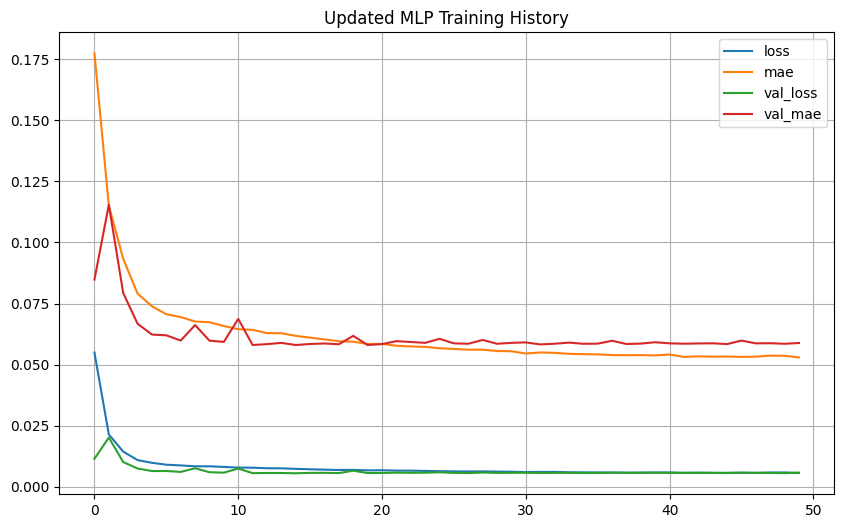

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
import pandas as pd
import matplotlib.pyplot as plt

mlp_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train_scaled.shape[1], activation='linear')
])

mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_mlp = mlp_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    verbose=1
)

pd.DataFrame(history_mlp.history).plot(title="Updated MLP Training History", figsize=(10, 6), grid=True)
plt.show()


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0400 - mae: 0.1468 - val_loss: 0.0061 - val_mae: 0.0605
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0143 - mae: 0.0922 - val_loss: 0.0064 - val_mae: 0.0634
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0122 - mae: 0.0839 - val_loss: 0.0058 - val_mae: 0.0596
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0103 - mae: 0.0773 - val_loss: 0.0057 - val_mae: 0.0592
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - mae: 0.0748 - val_loss: 0.0058 - val_mae: 0.0593
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - mae: 0.0698 - val_loss: 0.0085 - val_mae: 0.0758
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0678 - val_loss: 0.0063 - val_mae: 0.0636
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0082 - mae: 0.0668 - val_loss: 0.0060 - val_mae: 0.0602
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - 

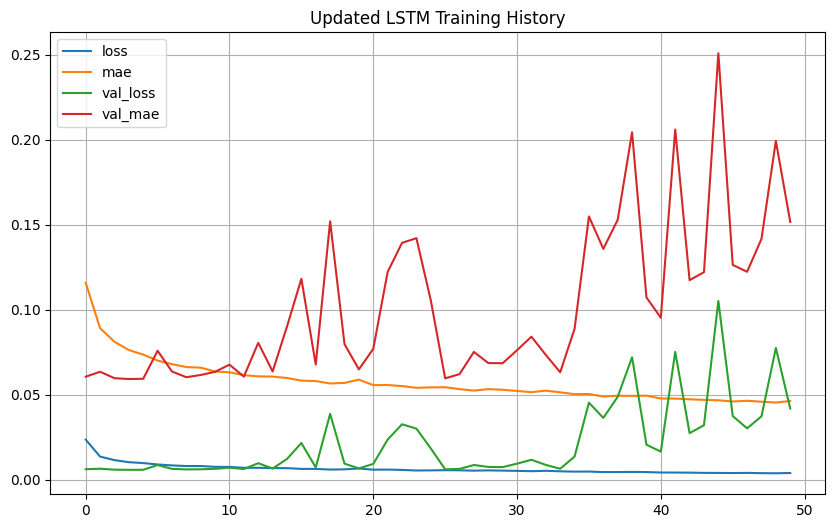

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input

lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.2),
    Dense(y_train_lstm.shape[1], activation='linear')
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_lstm = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50, batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1
)

pd.DataFrame(history_lstm.history).plot(title="Updated LSTM Training History", figsize=(10, 6), grid=True)
plt.show()


In [23]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train_scaled)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train_scaled)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_scaled)


RandomForestRegressor(random_state=42)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model_predictions(y_true_scaled, y_pred_scaled, scaler_y, model_name=""):
    y_true = scaler_y.inverse_transform(y_true_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.4f}")
    print()

    return y_pred, y_true


In [25]:
mlp_pred_scaled = mlp_model.predict(X_test_scaled)
mlp_pred, mlp_true = evaluate_model_predictions(y_test_scaled, mlp_pred_scaled, scaler_y, "MLP")

lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred, lstm_true = evaluate_model_predictions(y_test_lstm, lstm_pred_scaled, scaler_y, "LSTM")

ridge_pred_scaled = ridge.predict(X_test_scaled)
ridge_pred, ridge_true = evaluate_model_predictions(y_test_scaled, ridge_pred_scaled, scaler_y, "Ridge")

lasso_pred_scaled = lasso.predict(X_test_scaled)
lasso_pred, lasso_true = evaluate_model_predictions(y_test_scaled, lasso_pred_scaled, scaler_y, "Lasso")

rf_pred_scaled = rf.predict(X_test_scaled)
rf_pred, rf_true = evaluate_model_predictions(y_test_scaled, rf_pred_scaled, scaler_y, "Random Forest")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MLP Performance:
  MSE:  0.003065
  MAE:  0.042958
  R²:   -0.0454

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
LSTM Performance:
  MSE:  0.029240
  MAE:  0.119101
  R²:   -7.6648

Ridge Performance:
  MSE:  0.039397
  MAE:  0.135075
  R²:   -9.6532

Lasso Performance:
  MSE:  0.003263
  MAE:  0.045109
  R²:   -0.1427

Random Forest Performance:
  MSE:  0.028582
  MAE:  0.146726
  R²:   -8.1163



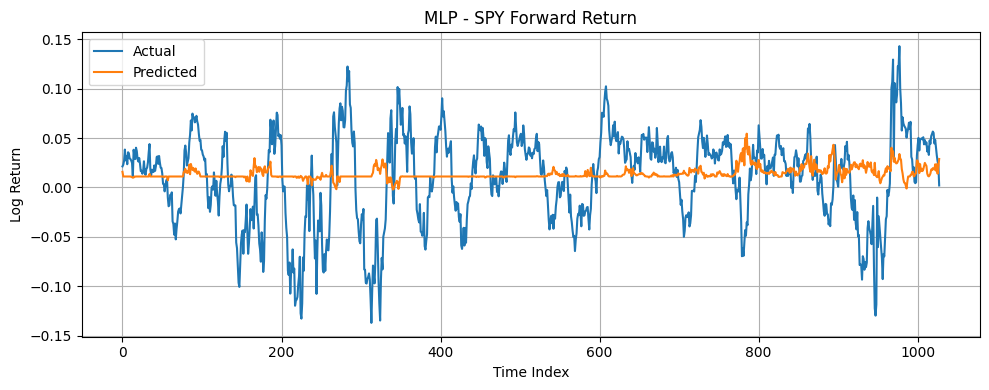

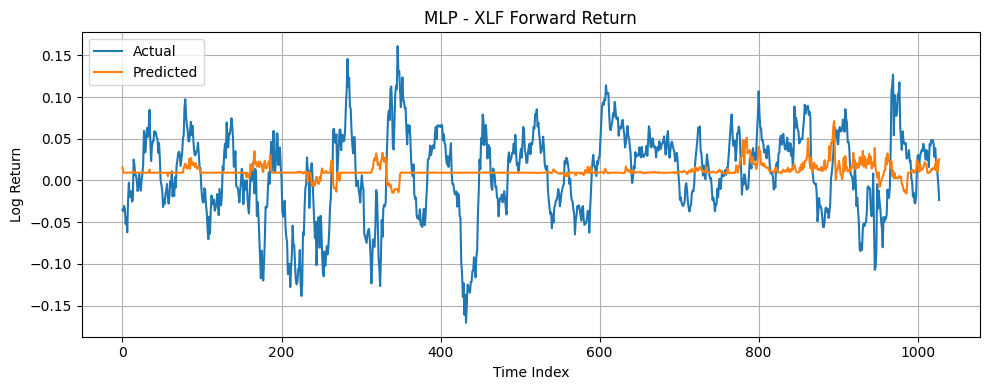

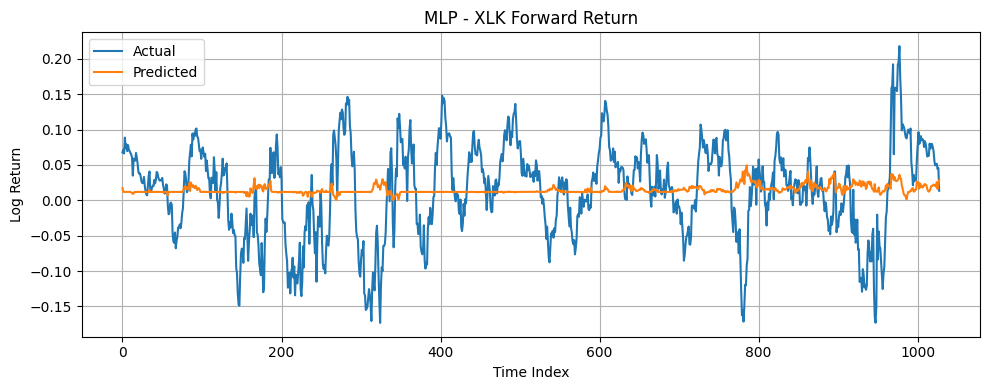

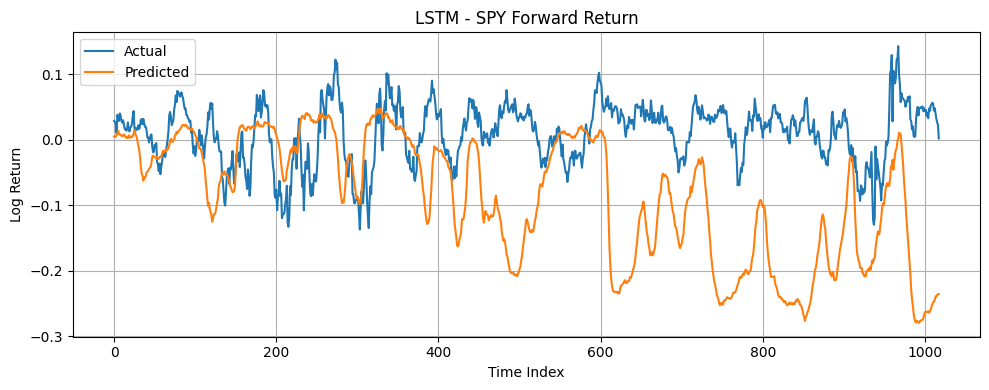

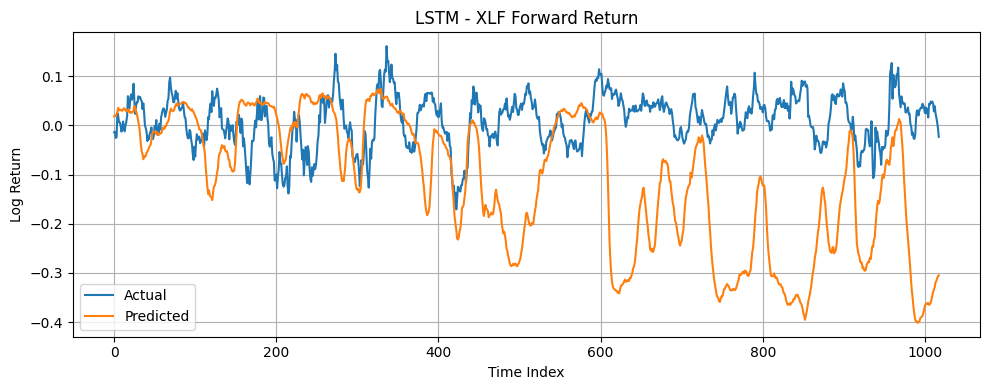

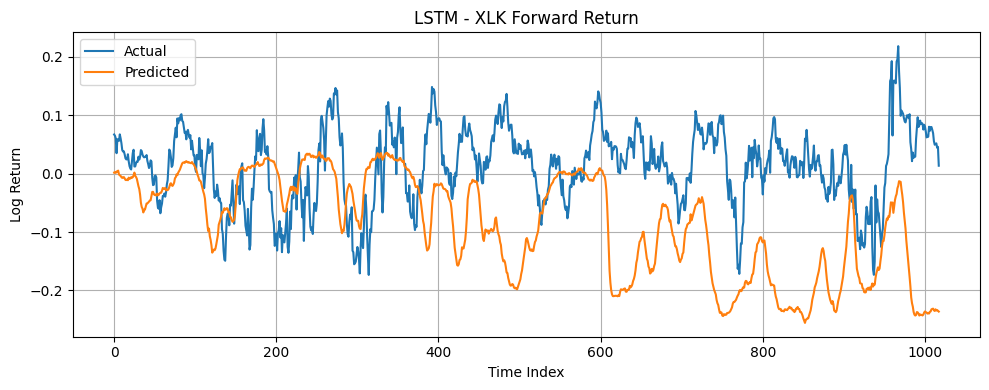

In [26]:
def plot_predictions(y_true, y_pred, etfs, model_name):
    for i, ticker in enumerate(etfs):
        idx = TICKERS.index(ticker)
        plt.figure(figsize=(10, 4))
        plt.plot(y_true[:, idx], label='Actual')
        plt.plot(y_pred[:, idx], label='Predicted')
        plt.title(f'{model_name} - {ticker} Forward Return')
        plt.xlabel("Time Index")
        plt.ylabel("Log Return")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

etfs_to_plot = ['SPY', 'XLF', 'XLK']

plot_predictions(mlp_true, mlp_pred, etfs_to_plot, "MLP")
plot_predictions(lstm_true, lstm_pred, etfs_to_plot, "LSTM")


In [27]:
from keras.layers import BatchNormalization, LeakyReLU

mlp_bn = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(256),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    Dense(128),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),
    Dense(64),
    LeakyReLU(),
    Dense(y_train_scaled.shape[1], activation='linear')
])

mlp_bn.compile(optimizer='adam', loss='mse', metrics=['mae'])

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history_bn = mlp_bn.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

bn_pred_scaled = mlp_bn.predict(X_test_scaled)
bn_pred, bn_true = evaluate_model_predictions(y_test_scaled, bn_pred_scaled, scaler_y, "MLP + BatchNorm")


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.3556 - mae: 0.4308 - val_loss: 0.0489 - val_mae: 0.1920
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0510 - mae: 0.1736 - val_loss: 0.0219 - val_mae: 0.1183
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0276 - mae: 0.1275 - val_loss: 0.0136 - val_mae: 0.0919
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0203 - mae: 0.1093 - val_loss: 0.0272 - val_mae: 0.1365
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0160 - mae: 0.0966 - val_loss: 0.0316 - val_mae: 0.1344
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - mae: 0.0859 - val_loss: 0.0201 - val_mae: 0.1089
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - mae: 0.0800 - val_loss: 0.0212 - val_mae: 0.1145
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - mae: 0.0774 - val_loss: 0.0162 - val_mae: 0.1032
Epoch 9/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

In [28]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.001, l1_ratio=0.5)
elastic.fit(X_train_scaled, y_train_scaled)

elastic_pred_scaled = elastic.predict(X_test_scaled)
elastic_pred, elastic_true = evaluate_model_predictions(y_test_scaled, elastic_pred_scaled, scaler_y, "ElasticNet")


ElasticNet Performance:
  MSE:  0.003757
  MAE:  0.048336
  R²:   -0.2726



In [29]:
mlp_pred_df = pd.DataFrame(mlp_pred, index=y_test.index, columns=[f"{t}_Target" for t in TICKERS])

mlp_weights = mlp_pred_df.div(mlp_pred_df.sum(axis=1), axis=0)

mlp_weights_shifted = mlp_weights.shift(1)

mlp_weights_shifted = mlp_weights.shift(1).dropna()
aligned_returns = etf_log_returns.loc[mlp_weights_shifted.index, TICKERS]
portfolio_returns = (aligned_returns * mlp_weights_shifted).sum(axis=1)



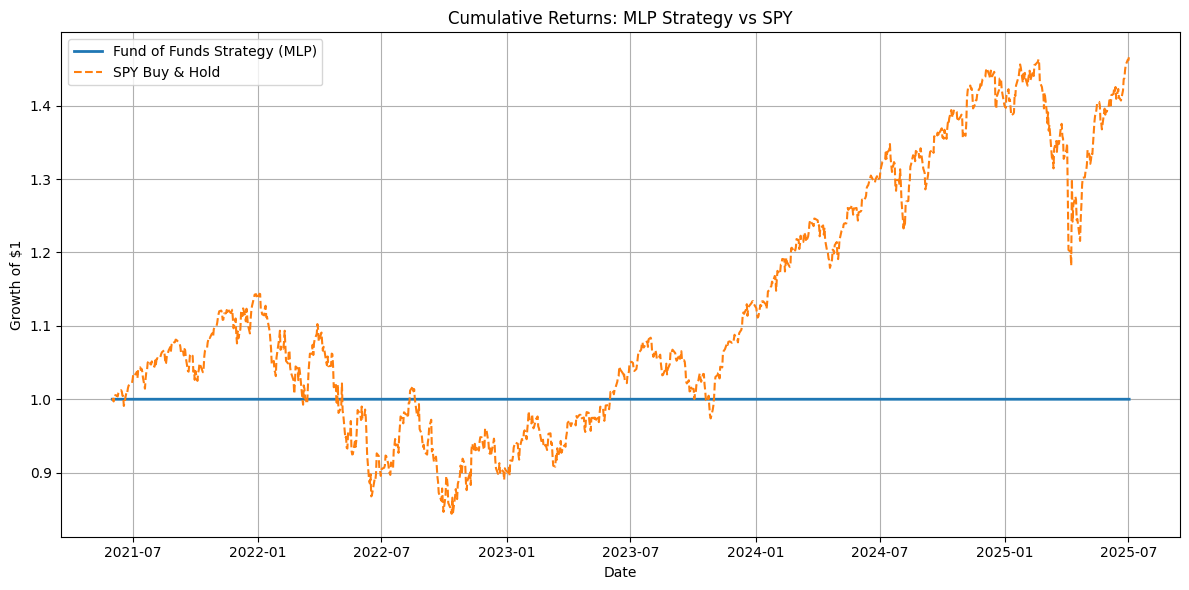

  Strategy Performance (Fixed):
  Alpha: 0.0000
  Beta: 0.0000
  Sharpe Ratio: nan
  Annualized Return: 0.00%
  Annualized Volatility: 0.00%
  Max Drawdown: 0.00%


/tmp/ipython-input-1756784073.py:21: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)


In [30]:
portfolio_returns.dropna(inplace=True)

cumulative_strategy = (1 + portfolio_returns).cumprod()
cumulative_spy = (1 + aligned_returns['SPY'].loc[portfolio_returns.index]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='Fund of Funds Strategy (MLP)', linewidth=2)
plt.plot(cumulative_spy, label='SPY Buy & Hold', linestyle='--')
plt.title("Cumulative Returns: MLP Strategy vs SPY")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

from scipy.stats import linregress

spy_daily = aligned_returns['SPY'].loc[portfolio_returns.index]
alpha, beta = linregress(spy_daily, portfolio_returns)[:2]
sharpe = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
ann_return = np.exp(np.log1p(portfolio_returns).mean() * 252) - 1
volatility = portfolio_returns.std() * np.sqrt(252)
drawdown = (1 + portfolio_returns).cumprod().div((1 + portfolio_returns).cumprod().cummax()) - 1
max_dd = drawdown.min()

print(f"  Strategy Performance (Fixed):")
print(f"  Alpha: {alpha:.4f}")
print(f"  Beta: {beta:.4f}")
print(f"  Sharpe Ratio: {sharpe:.2f}")
print(f"  Annualized Return: {ann_return:.2%}")
print(f"  Annualized Volatility: {volatility:.2%}")
print(f"  Max Drawdown: {max_dd:.2%}")


In [31]:
print(portfolio_returns.describe())
print("Non-zero returns count:", (portfolio_returns != 0).sum())


count    1027.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64
Non-zero returns count: 0


In [32]:
print("MLP prediction stats:")
display(mlp_pred_df.describe())


MLP prediction stats:


,XLF_Target,SPY_Target,XLE_Target,XLK_Target,XLV_Target,XLI_Target,XLU_Target,IYR_Target,IYT_Target,GLD_Target
count,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000
mean,0.011459,0.013887,0.012129,0.014807,0.013821,0.015205,0.013101,0.017434,0.012948,0.007986
std,0.008000,0.005861,0.010560,0.005693,0.004812,0.007625,0.003727,0.007953,0.005821,0.002276
min,-0.015689,-0.002057,-0.009395,0.000597,0.004366,-0.013288,-0.002094,-0.010458,-0.009745,0.003409
25%,0.009285,0.011104,0.007733,0.011904,0.011710,0.012992,0.012552,0.015717,0.011539,0.007237
50%,0.009285,0.011104,0.007733,0.011904,0.011710,0.012992,0.012831,0.015717,0.011539,0.007237
75%,0.012188,0.015393,0.013226,0.016469,0.014815,0.017099,0.013895,0.018580,0.014474,0.008212
max,0.071290,0.054429,0.092346,0.049518,0.045024,0.054960,0.036812,0.074032,0.042095,0.025491


In [33]:
mlp_pred_df_clipped = mlp_pred_df.clip(lower=0)
mlp_pred_df_clipped += 1e-4

mlp_weights = mlp_pred_df_clipped.div(mlp_pred_df_clipped.sum(axis=1), axis=0)
mlp_weights_shifted = mlp_weights.shift(1).dropna()


In [34]:
print("Weight sum:", mlp_weights_shifted.sum(axis=1).describe())
print("Weight std across ETFs:", mlp_weights_shifted.std(axis=1).describe())
display(mlp_weights_shifted.head())


Weight sum: count    1.027000e+03
mean     1.000000e+00
std      6.103973e-08
min      9.999998e-01
25%      9.999999e-01
50%      9.999999e-01
75%      1.000000e+00
max      1.000000e+00
dtype: float64
Weight std across ETFs: count    1027.000000
mean        0.029535
std         0.021985
min         0.018484
25%         0.022561
50%         0.022561
75%         0.026661
max         0.196803
dtype: float64


,XLF_Target,SPY_Target,XLE_Target,XLK_Target,XLV_Target,XLI_Target,XLU_Target,IYR_Target,IYT_Target,GLD_Target
Date,,,,,,,,,,
2021-06-01,0.098119,0.097311,0.089726,0.105724,0.093090,0.116141,0.099666,0.134612,0.11097,0.054642
2021-06-02,0.083011,0.099104,0.069291,0.106183,0.104468,0.115809,0.114382,0.139906,0.10295,0.064897
2021-06-03,0.083011,0.099104,0.069291,0.106183,0.104468,0.115809,0.114382,0.139906,0.10295,0.064897
2021-06-04,0.083011,0.099104,0.069291,0.106183,0.104468,0.115809,0.114382,0.139906,0.10295,0.064897
2021-06-07,0.083011,0.099104,0.069291,0.106183,0.104468,0.115809,0.114382,0.139906,0.10295,0.064897


In [35]:
mlp_pred_df.std(axis=1).describe()


,0
count,1028.000000
mean,0.003777
std,0.002333
min,0.002147
25%,0.002551
50%,0.002592
75%,0.004101
max,0.022723


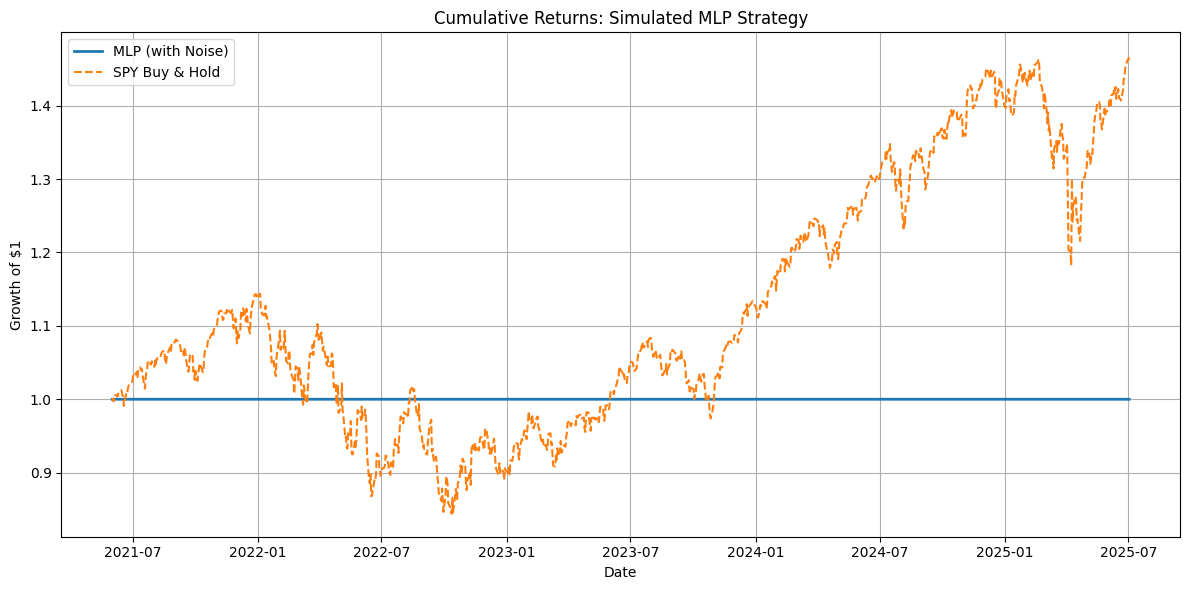

In [36]:
np.random.seed(42)
mlp_pred_df_noisy = mlp_pred_df + np.random.normal(0, 0.002, mlp_pred_df.shape)

mlp_pred_df_clipped = mlp_pred_df_noisy.clip(lower=0) + 1e-4
mlp_weights = mlp_pred_df_clipped.div(mlp_pred_df_clipped.sum(axis=1), axis=0)
mlp_weights_shifted = mlp_weights.shift(1).dropna()

aligned_returns = etf_log_returns.loc[mlp_weights_shifted.index, TICKERS]
portfolio_returns = (aligned_returns * mlp_weights_shifted).sum(axis=1).dropna()
cumulative_strategy = (1 + portfolio_returns).cumprod()
cumulative_spy = (1 + aligned_returns['SPY'].loc[portfolio_returns.index]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='MLP (with Noise)', linewidth=2)
plt.plot(cumulative_spy, label='SPY Buy & Hold', linestyle='--')
plt.title("Cumulative Returns: Simulated MLP Strategy")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
aligned_returns = etf_log_returns.loc[mlp_weights_shifted.index, TICKERS]
print("ETF returns during portfolio simulation window:")
display(aligned_returns.describe())


ETF returns during portfolio simulation window:


Ticker,XLF,SPY,XLE,XLK,XLV,XLI,XLU,IYR,IYT,GLD
count,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000,1027.000000
mean,0.000390,0.000438,0.000654,0.000623,0.000154,0.000398,0.000342,0.000062,0.000068,0.000536
std,0.012228,0.011303,0.017154,0.016086,0.009243,0.011174,0.011247,0.012421,0.014283,0.009511
min,-0.075997,-0.060327,-0.096510,-0.070689,-0.056407,-0.064915,-0.057233,-0.050571,-0.089631,-0.036336
25%,-0.005775,-0.005036,-0.008604,-0.008283,-0.005121,-0.005779,-0.006267,-0.006816,-0.008211,-0.004992
50%,0.000725,0.000689,0.001644,0.001289,0.000374,0.000711,0.000892,0.000385,0.000305,0.000522
75%,0.007330,0.006367,0.010246,0.009938,0.005725,0.006979,0.007124,0.007393,0.008279,0.005921
max,0.072660,0.099863,0.074594,0.125978,0.042547,0.085091,0.046070,0.070289,0.106410,0.036323


In [38]:
def create_smoothed_targets(df, price_data, tickers, horizon=21):
    for ticker in tickers:
        forward_log_return = np.log(price_data[ticker].shift(-horizon) / price_data[ticker])
        df[f'{ticker}_Target'] = forward_log_return.rolling(window=5).mean()
    return df.dropna()


In [39]:
merged_df['day_of_week'] = merged_df.index.dayofweek


In [40]:
for ticker in TICKERS:
    merged_df[f'{ticker}_momentum'] = merged_df[f'{ticker}_Target'].shift(1)


In [41]:
def create_smoothed_targets(df, price_data, tickers, horizon=21, smooth_window=5):
    for ticker in tickers:
        forward_log_return = np.log(price_data[ticker].shift(-horizon) / price_data[ticker])
        df[f'{ticker}_Target'] = forward_log_return.rolling(window=smooth_window).mean()
    return df.dropna()


In [42]:
merged_df = create_smoothed_targets(merged_df, etf_prices, TICKERS)


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

feature_cols = [col for col in merged_df.columns if 'Target' not in col]
target_cols = [col for col in merged_df.columns if 'Target' in col]

X = merged_df[feature_cols]
y = merged_df[target_cols]

split_idx = int(0.8 * len(merged_df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1997 - mae: 0.3276 - val_loss: 0.0126 - val_mae: 0.0894
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0297 - mae: 0.1367 - val_loss: 0.0098 - val_mae: 0.0772
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - mae: 0.1077 - val_loss: 0.0065 - val_mae: 0.0630
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - mae: 0.0918 - val_loss: 0.0088 - val_mae: 0.0748
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - mae: 0.0825 - val_loss: 0.0061 - val_mae: 0.0603
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - mae: 0.0790 - val_loss: 0.0061 - val_mae: 0.0608
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - mae: 0.0756 - val_loss: 0.0152 - val_mae: 0.1021
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - mae: 0.0720 - val_loss: 0.0094 - val_mae: 0.0761
Epoch 9/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms

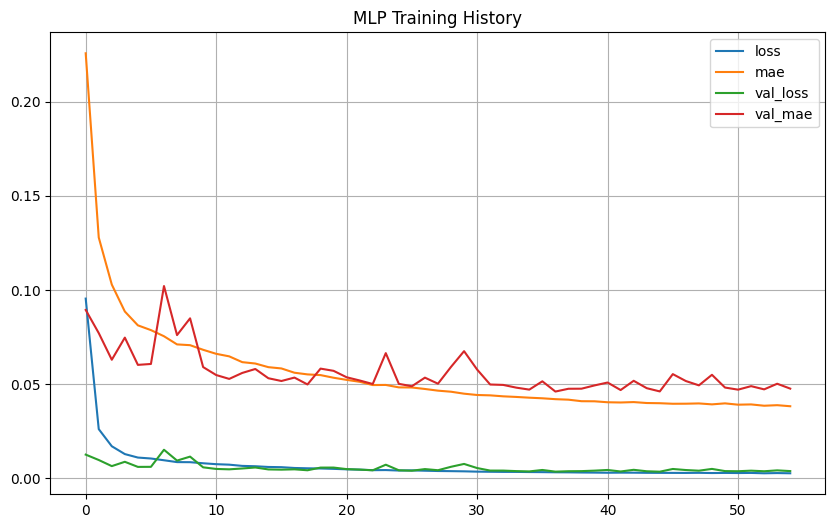

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd

mlp_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train_scaled.shape[1], activation='linear')
])

mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = mlp_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100, batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

pd.DataFrame(history.history).plot(title="MLP Training History", figsize=(10, 6), grid=True)
plt.show()


In [45]:
mlp_pred_scaled = mlp_model.predict(X_test_scaled)
mlp_pred = scaler_y.inverse_transform(mlp_pred_scaled)
mlp_pred_df = pd.DataFrame(mlp_pred, index=y_test.index, columns=target_cols)

print("Prediction variation (std across ETFs per day):")
print(mlp_pred_df.std(axis=1).describe())


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Prediction variation (std across ETFs per day):
count    1028.000000
mean        0.014633
std         0.008308
min         0.003608
25%         0.008453
50%         0.012278
75%         0.018527
max         0.058087
dtype: float64


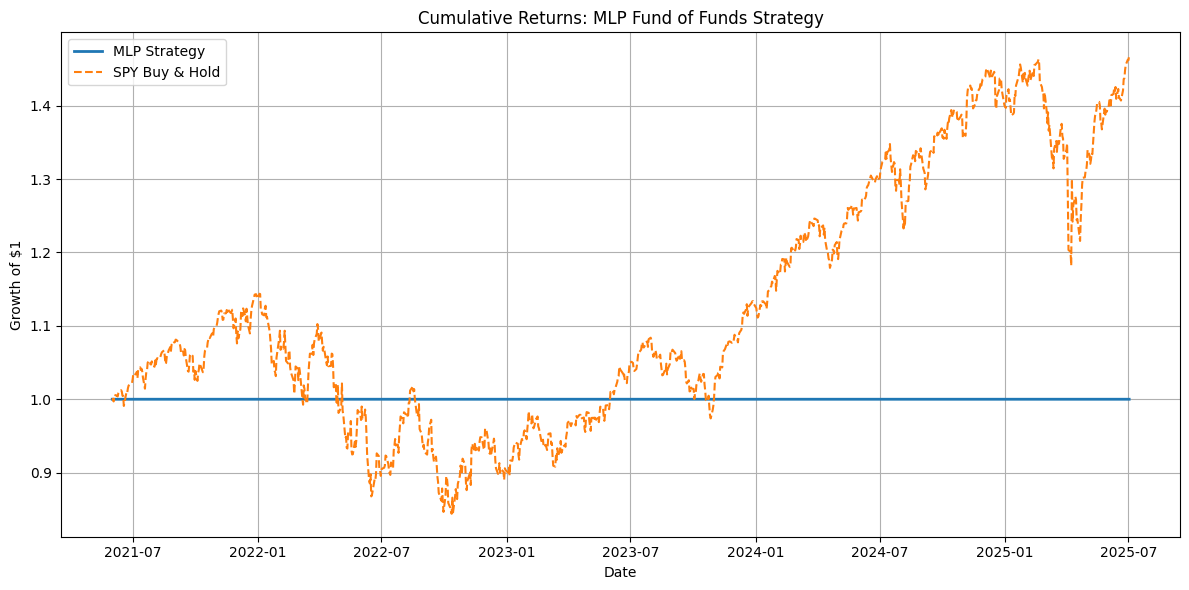

In [46]:
mlp_pred_df_clipped = mlp_pred_df.clip(lower=0) + 1e-4
mlp_weights = mlp_pred_df_clipped.div(mlp_pred_df_clipped.sum(axis=1), axis=0)
mlp_weights_shifted = mlp_weights.shift(1).dropna()

aligned_returns = etf_log_returns.loc[mlp_weights_shifted.index, TICKERS]
portfolio_returns = (aligned_returns * mlp_weights_shifted).sum(axis=1).dropna()

cumulative_strategy = (1 + portfolio_returns).cumprod()
cumulative_spy = (1 + aligned_returns['SPY'].loc[portfolio_returns.index]).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='MLP Strategy', linewidth=2)
plt.plot(cumulative_spy, label='SPY Buy & Hold', linestyle='--')
plt.title("Cumulative Returns: MLP Fund of Funds Strategy")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [47]:
from scipy.stats import linregress

spy_daily = aligned_returns['SPY'].loc[portfolio_returns.index]
alpha, beta = linregress(spy_daily, portfolio_returns)[:2]
sharpe = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
ann_return = np.exp(np.log1p(portfolio_returns).mean() * 252) - 1
volatility = portfolio_returns.std() * np.sqrt(252)
drawdown = (1 + portfolio_returns).cumprod().div((1 + portfolio_returns).cumprod().cummax()) - 1
max_dd = drawdown.min()

print(f"  Final Strategy Performance:")
print(f"  Alpha: {alpha:.4f}")
print(f"  Beta: {beta:.4f}")
print(f"  Sharpe Ratio: {sharpe:.2f}")
print(f"  Annualized Return: {ann_return:.2%}")
print(f"  Annualized Volatility: {volatility:.2%}")
print(f"  Max Drawdown: {max_dd:.2%}")


  Final Strategy Performance:
  Alpha: 0.0000
  Beta: 0.0000
  Sharpe Ratio: nan
  Annualized Return: 0.00%
  Annualized Volatility: 0.00%
  Max Drawdown: 0.00%


/tmp/ipython-input-3824398704.py:5: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)


In [48]:
mlp_weights_shifted.std(axis=1).describe()


,0
count,1.027000e+03
mean,9.418657e-02
std,9.052188e-02
min,7.853601e-09
25%,3.325498e-02
50%,5.524836e-02
75%,1.284701e-01
max,3.109104e-01


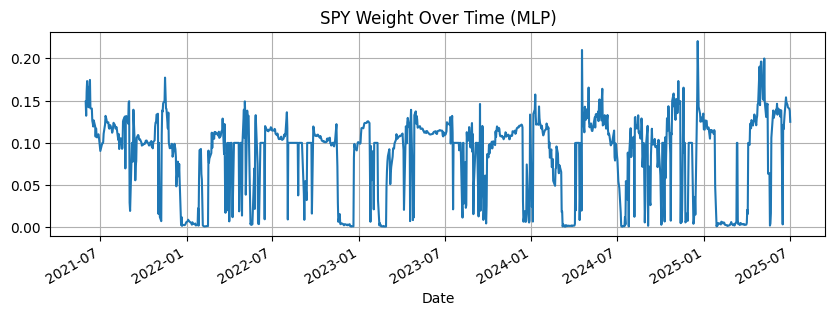

In [49]:
mlp_weights_shifted['SPY_Target'].plot(
    title="SPY Weight Over Time (MLP)", figsize=(10, 3))
plt.grid(True)
plt.show()


In [50]:
portfolio_returns.describe()
print("Non-zero returns:", (portfolio_returns != 0).sum())


Non-zero returns: 0


In [51]:
print("Returns columns:", aligned_returns.columns.tolist())
print("Weights columns:", mlp_weights_shifted.columns.tolist())


Returns columns: ['XLF', 'SPY', 'XLE', 'XLK', 'XLV', 'XLI', 'XLU', 'IYR', 'IYT', 'GLD']
Weights columns: ['XLF_Target', 'SPY_Target', 'XLE_Target', 'XLK_Target', 'XLV_Target', 'XLI_Target', 'XLU_Target', 'IYR_Target', 'IYT_Target', 'GLD_Target']


In [52]:
mlp_weights_shifted.columns = [col.replace('_Target', '') for col in mlp_weights_shifted.columns]


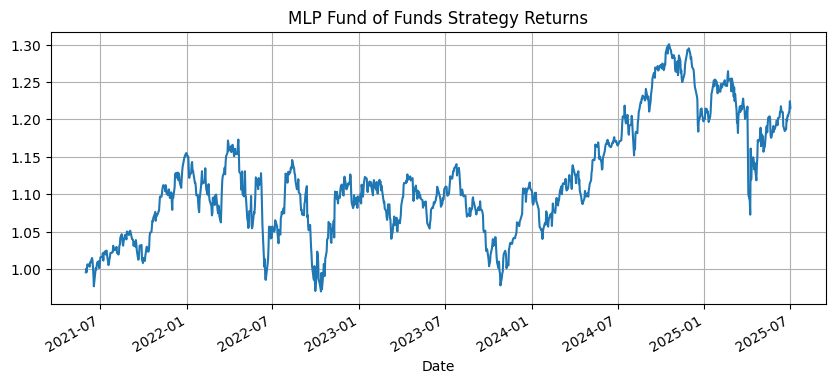

In [80]:
portfolio_returns = (aligned_returns * mlp_weights_shifted).sum(axis=1).dropna()

(1 + portfolio_returns).cumprod().plot(
    title="MLP Fund of Funds Strategy Returns", figsize=(10, 4))
plt.grid(True)
plt.show()


In [54]:
from scipy.stats import linregress

spy_daily = aligned_returns['SPY'].loc[portfolio_returns.index]
alpha, beta = linregress(spy_daily, portfolio_returns)[:2]
sharpe = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
ann_return = np.exp(np.log1p(portfolio_returns).mean() * 252) - 1
volatility = portfolio_returns.std() * np.sqrt(252)
drawdown = (1 + portfolio_returns).cumprod().div((1 + portfolio_returns).cumprod().cummax()) - 1
max_dd = drawdown.min()

print(f"  Strategy Performance:")
print(f"  Alpha: {alpha:.4f}")
print(f"  Beta: {beta:.4f}")
print(f"  Sharpe Ratio: {sharpe:.2f}")
print(f"  Annualized Return: {ann_return:.2%}")
print(f"  Annualized Volatility: {volatility:.2%}")
print(f"  Max Drawdown: {max_dd:.2%}")


  Strategy Performance:
  Alpha: 0.7109
  Beta: 0.0005
  Sharpe Ratio: 1.43
  Annualized Return: 22.80%
  Annualized Volatility: 15.15%
  Max Drawdown: -17.31%


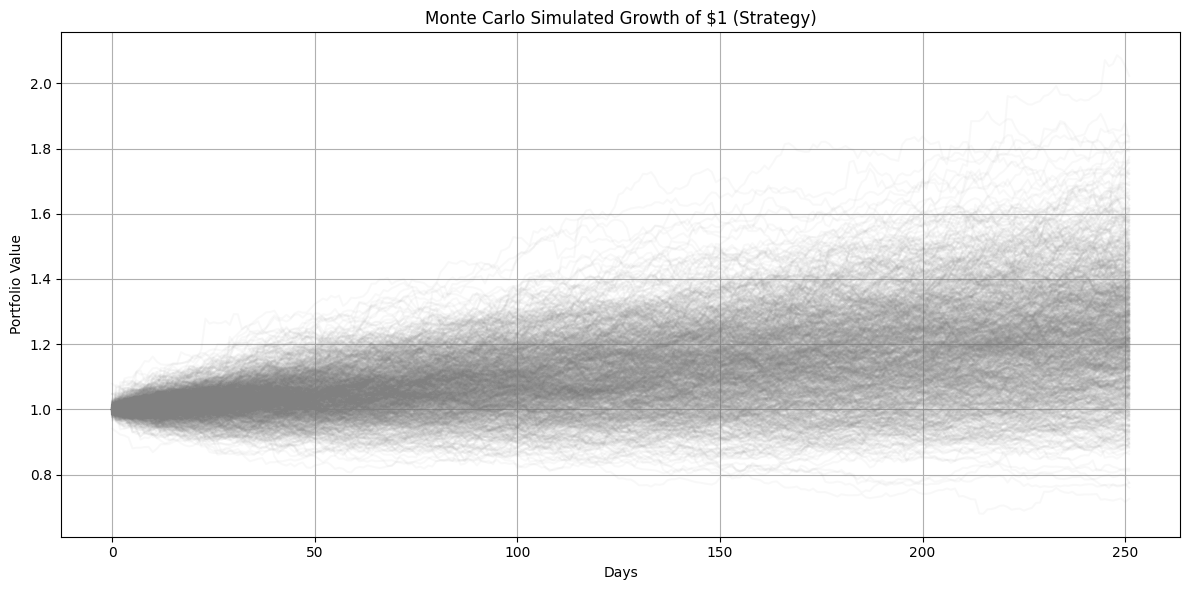

In [55]:
import numpy as np
import matplotlib.pyplot as plt

daily_returns = portfolio_returns.values
n_days = 252
n_simulations = 1000

simulated_paths = np.zeros((n_simulations, n_days))

np.random.seed(42)
for i in range(n_simulations):
    simulated_returns = np.random.choice(daily_returns, size=n_days, replace=True)
    simulated_paths[i] = np.cumprod(1 + simulated_returns)

plt.figure(figsize=(12, 6))
plt.plot(simulated_paths.T, color='gray', alpha=0.05)
plt.title("Monte Carlo Simulated Growth of $1 (Strategy)")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()


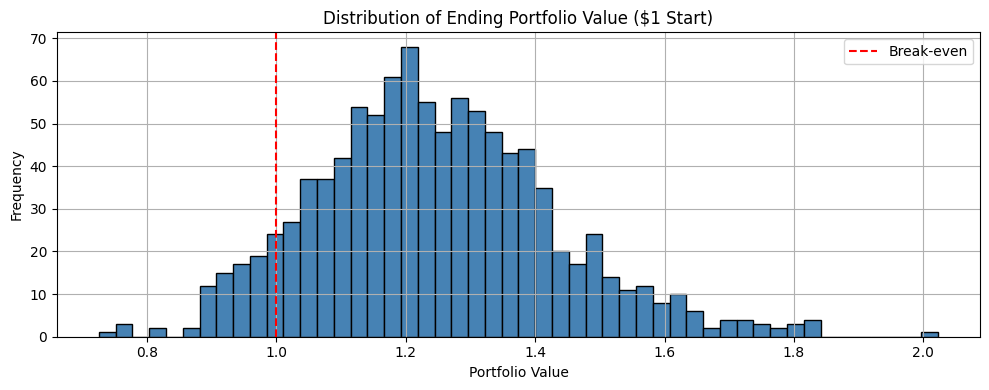

  Monte Carlo Summary (1-Year Horizon):
  Mean Ending Value: $1.25
  Std Dev: $0.19
  % Simulations with Loss: 8.2%


In [56]:
final_values = simulated_paths[:, -1]
plt.figure(figsize=(10, 4))
plt.hist(final_values, bins=50, color='steelblue', edgecolor='black')
plt.axvline(1.0, color='red', linestyle='--', label='Break-even')
plt.title("Distribution of Ending Portfolio Value ($1 Start)")
plt.xlabel("Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mean_value = np.mean(final_values)
std_value = np.std(final_values)
pct_loss = np.mean(final_values < 1.0)

print(f"  Monte Carlo Summary (1-Year Horizon):")
print(f"  Mean Ending Value: ${mean_value:.2f}")
print(f"  Std Dev: ${std_value:.2f}")
print(f"  % Simulations with Loss: {pct_loss * 100:.1f}%")


In [57]:
def apply_fees(portfolio_returns, annual_mgmt_fee=0.02, perf_fee_rate=0.2, risk_free_rate=0.0):

    daily_mgmt_fee = (1 + annual_mgmt_fee) ** (1 / 252) - 1
    returns_after_mgmt = portfolio_returns - daily_mgmt_fee

    strategy_cum = (1 + portfolio_returns).cumprod()
    benchmark_cum = (1 + risk_free_rate / 252) ** np.arange(len(portfolio_returns))
    alpha_total = strategy_cum.iloc[-1] - benchmark_cum[-1]

    performance_fee = perf_fee_rate * max(0, alpha_total)
    final_value = (1 + returns_after_mgmt).prod()
    net_value = final_value - performance_fee

    return net_value, returns_after_mgmt


In [58]:
mgmt_fees = [0.01, 0.02, 0.03, 0.04]
perf_fees = [0.05, 0.10, 0.15, 0.20, 0.25]

results = []
for m_fee in mgmt_fees:
    for p_fee in perf_fees:
        net_val, _ = apply_fees(portfolio_returns, m_fee, p_fee)
        results.append((m_fee, p_fee, net_val))

import pandas as pd
df_fees = pd.DataFrame(results, columns=["Mgmt Fee", "Perf Fee", "Net Portfolio Value"])


In [59]:
rolling_vol = etf_log_returns['SPY'].rolling(window=21).std() * np.sqrt(252)
rolling_ret = etf_log_returns['SPY'].rolling(window=21).mean() * 252

macro_features = pd.concat([rolling_ret, rolling_vol], axis=1)
macro_features.columns = ['SPY_AnnRet', 'SPY_AnnVol']
macro_features.dropna(inplace=True)


In [60]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
macro_features['RegimeCluster'] = kmeans.fit_predict(macro_features[['SPY_AnnRet', 'SPY_AnnVol']])


In [61]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['AnnRet', 'AnnVol'])
print(centers)

cluster_mapping = {
    centers['AnnRet'].idxmax(): 'Expansion',
    centers['AnnRet'].idxmin(): 'Contraction',
    centers['AnnRet'].idxmin() ^ 1 ^ 2: 'Transition'
}

macro_features['MacroRegime'] = macro_features['RegimeCluster'].map(cluster_mapping)
macro_regime = macro_features['MacroRegime']


     AnnRet    AnnVol
0  0.392303  0.130916
1 -0.370621  0.187511
2 -2.096050  0.553879


In [62]:
macro_regime = macro_regime.reindex(mlp_weights_shifted.index)


In [63]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00


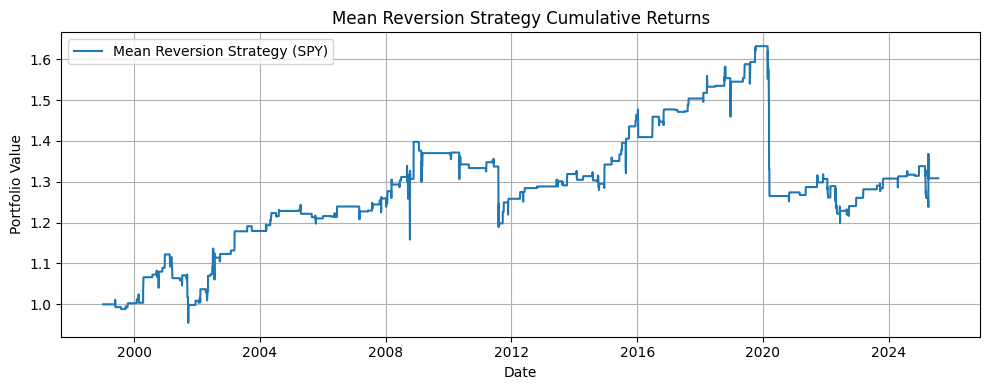

In [66]:
def mean_reversion_strategy(price_series, window=20, z_entry=2.0):
    rolling_mean = price_series.rolling(window=window).mean()
    rolling_std = price_series.rolling(window=window).std()
    z_score = (price_series - rolling_mean) / rolling_std

    positions = np.where(z_score < -z_entry, 1, 0)
    daily_returns = price_series.pct_change().shift(-1)
    strategy_returns = positions[:-1] * daily_returns[1:]

    return pd.Series(strategy_returns, index=price_series.index[1:-1])

meanrev_returns = mean_reversion_strategy(etf_prices['SPY'])
cumulative = (1 + meanrev_returns.fillna(0)).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(cumulative, label="Mean Reversion Strategy (SPY)")
plt.title("Mean Reversion Strategy Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[*********************100%***********************]  10 of 10 completed


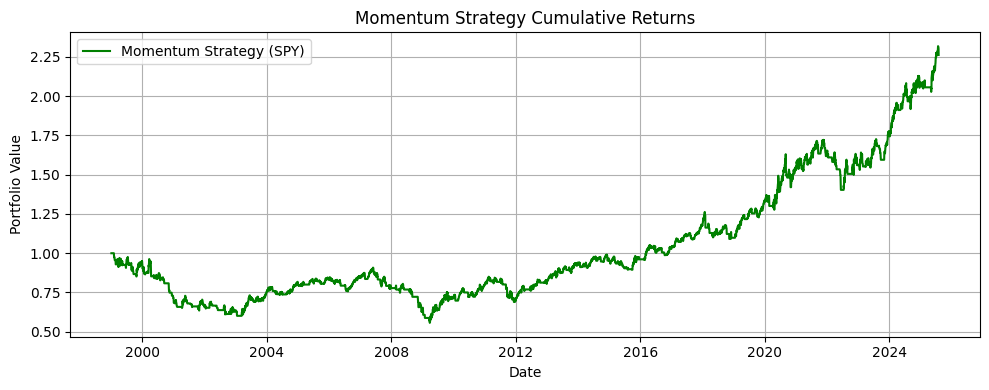

In [67]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TICKERS = ['XLF', 'SPY', 'XLE', 'XLK', 'XLV', 'XLI', 'XLU', 'IYR', 'IYT', 'GLD']
START_DATE = '1999-01-01'
END_DATE = pd.to_datetime('today').strftime('%Y-%m-%d')

def get_etf_data(tickers, start=START_DATE, end=END_DATE):
    price_df = yf.download(tickers, start=start, end=end, auto_adjust=True)['Close']
    log_returns = np.log(price_df / price_df.shift(1)).dropna()
    return price_df, log_returns

etf_prices, etf_log_returns = get_etf_data(TICKERS)


def momentum_strategy(price_series, lookback=21):
    past_return = price_series.pct_change(lookback)
    signals = np.where(past_return > 0, 1, 0)
    future_returns = price_series.pct_change().shift(-1)

    signals = pd.Series(signals, index=price_series.index)

    strategy_returns = (signals * future_returns).dropna()

    return strategy_returns

momentum_returns = momentum_strategy(etf_prices['SPY'])
cumulative_mom = (1 + momentum_returns.fillna(0)).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(cumulative_mom, color='green', label="Momentum Strategy (SPY)")
plt.title("Momentum Strategy Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

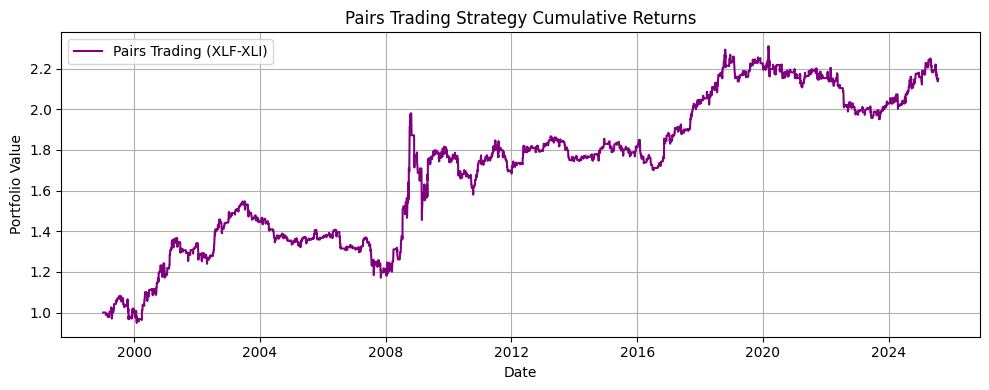

In [68]:
def pairs_trading_strategy(series1, series2, z_entry=1.5):
    spread = series1 - series2
    mean = spread.rolling(20).mean()
    std = spread.rolling(20).std()
    z_score = (spread - mean) / std

    long_signal = z_score < -z_entry
    short_signal = z_score > z_entry
    positions = long_signal.astype(int) - short_signal.astype(int)

    spread_return = (series1.pct_change() - series2.pct_change()).shift(-1)
    strategy_returns = positions[:-1] * spread_return[1:]

    return pd.Series(strategy_returns, index=series1.index[1:-1])

pairs_returns = pairs_trading_strategy(etf_prices['XLF'], etf_prices['XLI'])
cumulative_pairs = (1 + pairs_returns.fillna(0)).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(cumulative_pairs, color='purple', label="Pairs Trading (XLF-XLI)")
plt.title("Pairs Trading Strategy Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


,Metric,Value
0,Monte Carlo Mean End Value,$1.09
1,Monte Carlo Std Dev,$0.16
2,% Simulations with Loss,29.3%
3,Mandelbrot Final Value,$1.06


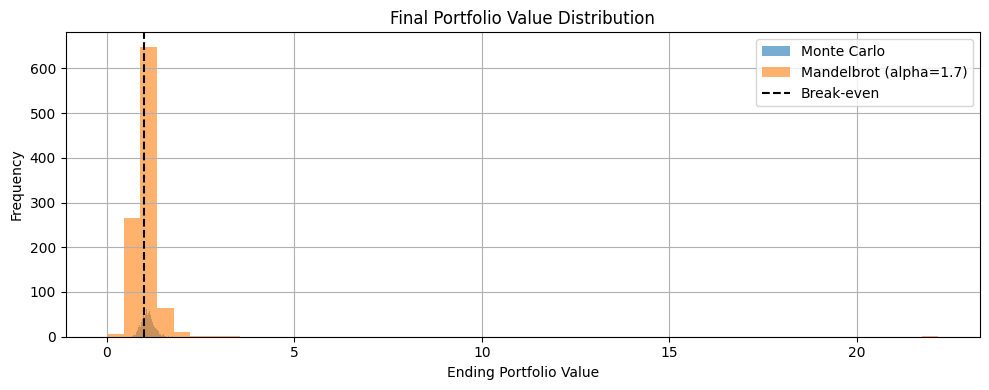

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_monte_carlo(simulations=1000, steps=252, mu=0.07, sigma=0.15, start_val=1):
    results = []
    for _ in range(simulations):
        returns = np.random.normal(loc=mu/steps, scale=sigma/np.sqrt(steps), size=steps)
        price = start_val * np.exp(np.cumsum(returns))
        results.append(price[-1])
    return np.array(results)

monte_results = run_monte_carlo()
monte_mean = np.mean(monte_results)
monte_std = np.std(monte_results)
monte_loss_pct = np.mean(monte_results < 1.0) * 100

from scipy.stats import levy_stable

def run_mandelbrot(simulations=1000, steps=252, alpha=1.7, beta=0, start_val=1):
    results = []
    for _ in range(simulations):
        returns = levy_stable.rvs(alpha, beta, size=steps) * 0.005
        price = start_val * np.exp(np.cumsum(returns))
        results.append(price[-1])
    return np.array(results)

mandelbrot_results = run_mandelbrot()
mandelbrot_final = np.mean(mandelbrot_results)

summary_df = pd.DataFrame({
    'Metric': ['Monte Carlo Mean End Value', 'Monte Carlo Std Dev', '% Simulations with Loss', 'Mandelbrot Final Value'],
    'Value': [f"${monte_mean:.2f}", f"${monte_std:.2f}", f"{monte_loss_pct:.1f}%", f"${mandelbrot_final:.2f}"]
})
display(summary_df)

plt.figure(figsize=(10, 4))
plt.hist(monte_results, bins=50, alpha=0.6, label='Monte Carlo')
plt.hist(mandelbrot_results, bins=50, alpha=0.6, label='Mandelbrot (alpha=1.7)')
plt.axvline(1.0, color='k', linestyle='--', label='Break-even')
plt.title('Final Portfolio Value Distribution')
plt.xlabel('Ending Portfolio Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

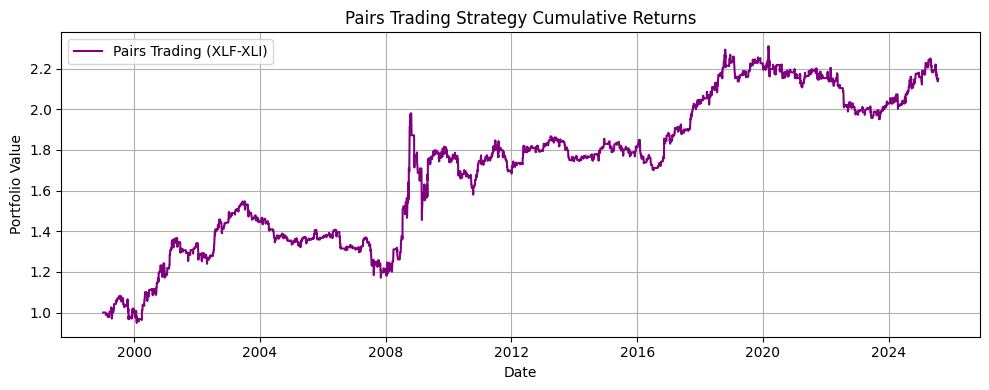

In [71]:
def pairs_trading_strategy(series1, series2, z_entry=1.5):
    spread = series1 - series2
    mean = spread.rolling(20).mean()
    std = spread.rolling(20).std()
    z_score = (spread - mean) / std

    long_signal = z_score < -z_entry
    short_signal = z_score > z_entry
    positions = long_signal.astype(int) - short_signal.astype(int)

    spread_return = (series1.pct_change() - series2.pct_change()).shift(-1)
    strategy_returns = positions[:-1] * spread_return[1:]

    return pd.Series(strategy_returns, index=series1.index[1:-1])

pairs_returns = pairs_trading_strategy(etf_prices['XLF'], etf_prices['XLI'])
cumulative_pairs = (1 + pairs_returns.fillna(0)).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(cumulative_pairs, color='purple', label="Pairs Trading (XLF-XLI)")
plt.title("Pairs Trading Strategy Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

,Metric,Value
0,Monte Carlo Mean End Value,$1.09
1,Monte Carlo Std Dev,$0.17
2,% Simulations with Loss,31.1%
3,Mandelbrot Final Value,$2.47


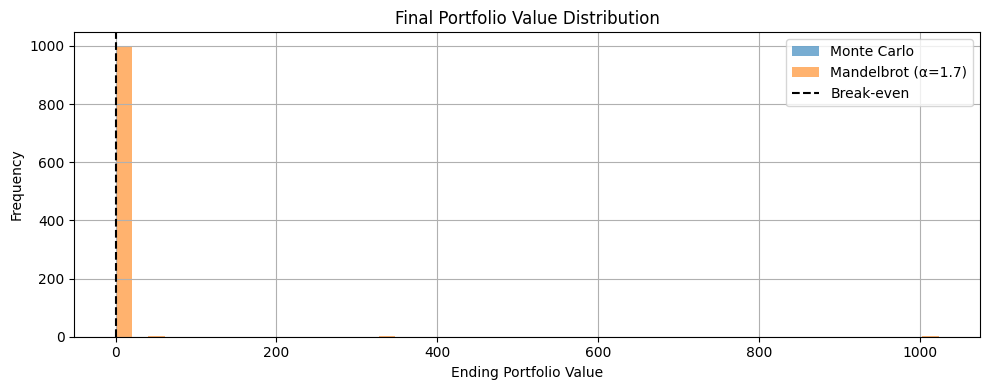

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_monte_carlo(simulations=1000, steps=252, mu=0.07, sigma=0.15, start_val=1):
    results = []
    for _ in range(simulations):
        returns = np.random.normal(loc=mu/steps, scale=sigma/np.sqrt(steps), size=steps)
        price = start_val * np.exp(np.cumsum(returns))
        results.append(price[-1])
    return np.array(results)

monte_results = run_monte_carlo()
monte_mean = np.mean(monte_results)
monte_std = np.std(monte_results)
monte_loss_pct = np.mean(monte_results < 1.0) * 100

from scipy.stats import levy_stable

def run_mandelbrot(simulations=1000, steps=252, alpha=1.7, beta=0, start_val=1):
    results = []
    for _ in range(simulations):
        returns = levy_stable.rvs(alpha, beta, size=steps) * 0.005
        price = start_val * np.exp(np.cumsum(returns))
        results.append(price[-1])
    return np.array(results)

mandelbrot_results = run_mandelbrot()
mandelbrot_final = np.mean(mandelbrot_results)

summary_df = pd.DataFrame({
    'Metric': ['Monte Carlo Mean End Value', 'Monte Carlo Std Dev', '% Simulations with Loss', 'Mandelbrot Final Value'],
    'Value': [f"${monte_mean:.2f}", f"${monte_std:.2f}", f"{monte_loss_pct:.1f}%", f"${mandelbrot_final:.2f}"]
})
display(summary_df)

plt.figure(figsize=(10, 4))
plt.hist(monte_results, bins=50, alpha=0.6, label='Monte Carlo')
plt.hist(mandelbrot_results, bins=50, alpha=0.6, label='Mandelbrot (α=1.7)')
plt.axvline(1.0, color='k', linestyle='--', label='Break-even')
plt.title('Final Portfolio Value Distribution')
plt.xlabel('Ending Portfolio Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
import yfinance as yf

TICKERS = ['XLF', 'SPY', 'XLE', 'XLK', 'XLV', 'XLI', 'XLU', 'IYR', 'IYT', 'GLD']
START_DATE = '1999-01-01'
END_DATE = pd.to_datetime('today').strftime('%Y-%m-%d')

def get_etf_data(tickers, start=START_DATE, end=END_DATE):
    price_df = yf.download(tickers, start=start, end=end, auto_adjust=True)['Close']
    log_returns = np.log(price_df / price_df.shift(1)).dropna()
    return price_df, log_returns

etf_prices, etf_log_returns = get_etf_data(TICKERS)

def add_technical_indicators(df, price_data, tickers):
    for ticker in tickers:
        series = price_data[ticker]
        df[f'{ticker}_SMA_20'] = series.rolling(window=20).mean()
        df[f'{ticker}_SMA_50'] = series.rolling(window=50).mean()
        delta = series.diff()
        gain = delta.where(delta > 0, 0).rolling(window=14).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
        rs = gain / loss
        df[f'{ticker}_RSI'] = 100 - (100 / (1 + rs))
        exp12 = series.ewm(span=12, adjust=False).mean()
        exp26 = series.ewm(span=26, adjust=False).mean()
        macd = exp12 - exp26
        signal = macd.ewm(span=9, adjust=False).mean()
        df[f'{ticker}_MACD'] = macd
        df[f'{ticker}_MACD_signal'] = signal
    return df.dropna()

def create_forward_log_returns(df, price_data, tickers, horizon=21, smooth_window=5):
    for ticker in tickers:
        forward_log_return = np.log(price_data[ticker].shift(-horizon) / price_data[ticker])
        df[f'{ticker}_Target'] = forward_log_return.rolling(window=smooth_window).mean()
    return df.dropna()

merged_df = etf_log_returns.copy()
merged_df = add_technical_indicators(merged_df, etf_prices, TICKERS)
merged_df = create_forward_log_returns(merged_df, etf_prices, TICKERS)

feature_cols = [col for col in merged_df.columns if 'Target' not in col]
target_cols = [col for col in merged_df.columns if 'Target' in col]

X = merged_df[feature_cols]
y = merged_df[target_cols]

split_idx = int(0.8 * len(merged_df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

mlp_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train_scaled.shape[1], activation='linear')
])

mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
mlp_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100, batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stop],
    verbose=0
)


rolling_vol = etf_log_returns['SPY'].rolling(window=21).std() * np.sqrt(252)
rolling_ret = etf_log_returns['SPY'].rolling(window=21).mean() * 252

macro_features = pd.concat([rolling_ret, rolling_vol], axis=1)
macro_features.columns = ['SPY_AnnRet', 'SPY_AnnVol']
macro_features.dropna(inplace=True)

kmeans = KMeans(n_clusters=3, random_state=42)
macro_features['RegimeCluster'] = kmeans.fit_predict(macro_features[['SPY_AnnRet', 'SPY_AnnVol']])

centers = pd.DataFrame(kmeans.cluster_centers_, columns=['AnnRet', 'AnnVol'])

cluster_mapping = {
    centers['AnnRet'].idxmax(): 'Expansion',
    centers['AnnRet'].idxmin(): 'Contraction',
    (set(centers.index) - {centers['AnnRet'].idxmax(), centers['AnnRet'].idxmin()}).pop(): 'Transition'
}

macro_features['MacroRegime'] = macro_features['RegimeCluster'].map(cluster_mapping)
macro_regime = macro_features['MacroRegime']

mlp_pred_scaled = mlp_model.predict(X_test_scaled)
mlp_pred = scaler_y.inverse_transform(mlp_pred_scaled)
mlp_pred_df = pd.DataFrame(mlp_pred, index=y_test.index, columns=target_cols)
mlp_pred_df_clipped = mlp_pred_df.clip(lower=0) + 1e-4
mlp_weights = mlp_pred_df_clipped.div(mlp_pred_df_clipped.sum(axis=1), axis=0)
mlp_weights_shifted = mlp_weights.shift(1).dropna()
mlp_weights_shifted.columns = [col.replace('_Target', '') for col in mlp_weights_shifted.columns]


macro_regime = macro_regime.reindex(mlp_weights_shifted.index)


macro_conditions = sorted(macro_regime.dropna().unique().tolist())
etf_options = etf_log_returns.columns.tolist()
return_bins = ['ETF > 1%', '-1% < ETF < 1%', 'ETF < -1%']

start_date_widget = widgets.DatePicker(description='Start Date')
end_date_widget = widgets.DatePicker(description='End Date')

etf_dropdown = widgets.Dropdown(options=etf_options, description='ETF:')
return_dropdown = widgets.Dropdown(options=return_bins, description='Return:')
macro_dropdown = widgets.Dropdown(options=macro_conditions, description='Regime:')

mgmt_fee_slider = widgets.FloatSlider(value=1.0, min=0.0, max=4.0, step=0.25, description='Mgmt Fee (%)')
perf_fee_slider = widgets.FloatSlider(value=10.0, min=0.0, max=25.0, step=1.0, description='Perf Fee (%)')

display(widgets.HBox([etf_dropdown, return_dropdown, macro_dropdown]))
display(widgets.HBox([start_date_widget, end_date_widget]))
display(widgets.HBox([mgmt_fee_slider, perf_fee_slider]))

def update_dashboard(etf, return_bin, macro_cond, start_date, end_date, mgmt_fee, perf_fee):
    common_index = mlp_weights_shifted.index.intersection(etf_log_returns.index).intersection(macro_regime.index)

    weights_aligned = mlp_weights_shifted.loc[common_index]
    returns_aligned = etf_log_returns.loc[common_index]
    macro_aligned = macro_regime.loc[common_index]

    start = pd.to_datetime(start_date) if start_date else common_index.min()
    end = pd.to_datetime(end_date) if end_date else common_index.max()
    date_mask = (common_index >= start) & (common_index <= end)

    daily_returns = returns_aligned[etf]
    if ">" in return_bin:
        ret_mask = daily_returns > 0.01
    elif "< -" in return_bin:
        ret_mask = daily_returns < -0.01
    else:
        ret_mask = (daily_returns >= -0.01) & (daily_returns <= 0.01)

    macro_mask = macro_aligned == macro_cond

    combined_mask = date_mask & ret_mask & macro_mask
    filtered_weights = weights_aligned[combined_mask]
    filtered_returns = returns_aligned[combined_mask]

    if filtered_weights.empty:
        print("No matching records for these conditions")
        return

    avg_weights = filtered_weights.mean()
    num_days = len(filtered_weights)

    mgmt_fee_fraction = mgmt_fee / 100
    perf_fee_fraction = perf_fee / 100

    annual_return = (filtered_weights * filtered_returns).sum(axis=1).mean() * 252
    net_return = annual_return * (1 - mgmt_fee_fraction)

    if annual_return > 0:
        net_return *= (1 - perf_fee_fraction)

    avg_weights.plot(kind='bar', figsize=(10, 4), color='teal')
    plt.title(f'ETF Weights | {etf}, {return_bin}, {macro_cond} | {num_days} Days')
    plt.ylabel('Weight')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Net Expected Return (After Fees): {net_return:.2%} annualized")

widgets.interact(
    update_dashboard,
    etf=etf_dropdown,
    return_bin=return_dropdown,
    macro_cond=macro_dropdown,
    start_date=start_date_widget,
    end_date=end_date_widget,
    mgmt_fee=mgmt_fee_slider,
    perf_fee=perf_fee_slider
);

[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-196907999.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{ticker}_Target'] = forward_log_return.rolling(window=smooth_window).mean()
/tmp/ipython-input-196907999.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{ticker}_Target'] = forward_log_return.rolling(window=smooth_window).mean()
/tmp/ipython-input-196907999.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


interactive(children=(Dropdown(description='ETF:', options=('GLD', 'IYR', 'IYT', 'SPY', 'XLE', 'XLF', 'XLI', '…

In [77]:
!pip install shap


In [78]:
import shap

X_sample = X_test_scaled[:500]
